In [2]:
import os
import torch
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
# %matplotlib inline
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset, MoleculeNet

from models import GCN
from utils.utils import atom_type_count, to_molecule, attribution_visualize, aggregate_edge_directions, attribution_visualize_edge
from captum.attr import Saliency, IntegratedGradients
from torch_geometric.explain import Explainer, PGExplainer, GNNExplainer
from IPython.display import Image, display


config = {
    'dataset': 'ESOL',
    'batch_size': 128,
    'train': False,
    "lr": 0.001,
    "epochs": 100,
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "img_save_dir": "./ouput",
    "explain_topk": 10,
}
device = config['device']
# create output directory
os.makedirs(config['img_save_dir'], exist_ok=True)

Atom types:  {'S', 'O', 'N', 'P', 'C', 'Cl', 'F', 'I', 'Br'}
GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249
Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])


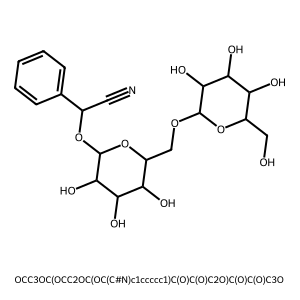

Original molecule
--------------------------------------------------
Explanation(node_mask=[1, 9], target=[1, 1], x=[32, 9], edge_index=[2, 68])
tensor([[0.4822, 0.0000, 0.5235, 0.5283, 0.4616, 0.0000, 0.4666, 0.3655, 0.3753]])


In [4]:

dataset = MoleculeNet('MoleculeNet', config['dataset'])
test_dataset = dataset[:len(dataset) // 10]
valid_dataset = dataset[len(dataset) // 10:2 * len(dataset) // 10]
train_dataset = dataset[2 * len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# print("Dataset type: ", type(dataset))
# print("Dataset features: ", dataset.num_features)
# print("Dataset length: ", dataset.len)
# print("Dataset splits: train, valid, test: ", len(train_dataset), len(valid_dataset), len(test_dataset))
# print("Dataset sample: ", dataset[0])
# print("Sample  nodes: ", dataset[0].num_nodes)
# print("Sample  edges: ", dataset[0].num_edges)

# count atom types
atom_types = atom_type_count(dataset)
print("Atom types: ", atom_types)



model = GCN()
print(model)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.7, patience=5,
                                                       min_lr=1e-10)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
model.load_state_dict(torch.load(f"gnn_model_{config['dataset'].lower()}.pth"))
model.eval()


visualize_index = 0

data = test_dataset[visualize_index]
print(data)
molecule = Chem.MolFromSmiles(dataset[0]["smiles"])
img_save_path = f"{config['img_save_dir']}/{config['dataset']}/{visualize_index}/original.png"
os.makedirs(f"{config['img_save_dir']}/{config['dataset']}/{visualize_index}", exist_ok=True)
attribution_visualize(dataset[0]["smiles"], {}, {}, img_save_path)
img = Image(filename='{}_atom.png'.format(data["smiles"]))
display(img)
print("Original molecule")
print('-' * 50)


def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x.float(), data.edge_index, batch, edge_mask)
    return out

# node feature

gnnexplainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='phenomenon',
    node_mask_type='common_attributes',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
),
# Include only the top 10 most important edges:
threshold_config=dict(threshold_type='topk', value=config['explain_topk']),
)

explanation = gnnexplainer(data.x.float(), data.edge_index, batch_index=data.batch, target=data.y)
print(explanation)
print(explanation.node_mask)

"""
        row.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
        row.append(x_map['chirality'].index(str(atom.GetChiralTag())))
        row.append(x_map['degree'].index(atom.GetTotalDegree()))
        row.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
        row.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
        row.append(x_map['num_radical_electrons'].index(atom.GetNumRadicalElectrons()))
        row.append(x_map['hybridization'].index(str(atom.GetHybridization())))
        row.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
        row.append(x_map['is_in_ring'].index(atom.IsInRing()))
"""
